In [521]:
from matplotlib.pylab import *
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
π = pi

In [522]:
style.use(['dark_background', 'bmh'])
%matplotlib notebook

Car-trailer diagram (inverted image `car-trainer-k.png` available as well):
![car-trailer](car-trailer-w.png)

Car-trailer equation:
\begin{align}
\dot x &= s \cos \theta_0 \\
\dot y &= s \sin \theta_0 \\
\dot \theta_0 &= \frac{s}{L} \tan \phi \\
\dot \theta_1 &= \frac{s}{d_1} \sin(\theta_1 - \theta_0)
\end{align}
where $s$: signed speed, $\phi$: negative steering angle,

In [523]:
class Truck:
    def __init__(self, display=False):

        self.W = 1  # car and trailer width, for drawing only
        self.L = 1 * self.W  # car length
        self.d = 4 * self.L  # d_1
        self.s = -0.1  # speed
        self.display = display
        
        self.box = [0, 40, -10, 10]
        if self.display:
            self.f = figure(figsize=(10, 5), num='The truck backer-upper', facecolor='none')
            self.ax = self.f.add_axes([0.01, 0.01, 0.98, 0.98], facecolor='black')
            self.patches = list()
            
            self.ax.axis('equal')
            b = self.box
            self.ax.axis([b[0] - 1, b[1], b[2], b[3]])
            self.ax.set_xticks([], []); self.ax.set_yticks([], [])
            self.ax.axhline(); self.ax.axvline()

        self.reset()
    
    
    def set_state(self, x=None, y=None, θ0=None, θ1=None, ϕ=0):

        self.ϕ = ϕ  # car initial steering angle
        
        self.θ0 = θ0 
        self.θ1 = θ1 
        self.x = x 
        self.y = y 

        # Draw, if display is True
        if self.display: self.draw()
    
    
    def reset(self, x=None, y=None, θ0=None, θ1=None, ϕ=0):
        self.ϕ = ϕ  # car initial steering angle
        
        # self.θ0 = deg2rad(30)  # car initial direction
        # self.θ1 = deg2rad(-30)  # trailer initial direction
        # self.x, self.y = 20, -5  # initial car coordinates
        
        self.θ0 = θ0 if θ0 else random() * 2 * π  # 0 <= ϑ₀ < 2π
        self.θ1 = θ1 if θ1 else (random() - 0.5) * π / 2 + self.θ0  # -π/4 <= ϑ₁ - ϑ₀ < π/4
        self.x = x if x else (random() * .75 + 0.25) * self.box[1]
        self.y = y if y else (random() - 0.5) * (self.box[3] - self.box[2])
        
        # If poorly initialise, then re-initialise
        if not self.valid():
            self.reset(ϕ)
        
        # Draw, if display is True
        if self.display: self.draw()
    
    def step(self, ϕ=0, dt=1):
        
        # Check for illegal conditions
        if self.is_jackknifed():
#             print('The truck is jackknifed!')
            return
        
        if self.is_offscreen():
            print('The car or trailer is off screen')
            return
        
        self.ϕ = ϕ
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        # Perform state update
        self.x += s * cos(θ0) * dt
        self.y += s * sin(θ0) * dt
        self.θ0 += s / L * tan(ϕ) * dt
        self.θ1 += s / d * sin(θ0 - θ1) * dt
        
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def state(self):
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def _get_atributes(self):
        return (
            self.x, self.y, self.W, self.L, self.d, self.s,
            self.θ0, self.θ1, self.ϕ
        )
    
    def _traler_xy(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return x - d * cos(θ1), y - d * sin(θ1)
        
    def is_jackknifed(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return abs(θ0 - θ1) * 180 / π > 90
    
    def is_offscreen(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        x1, y1 = x + 1.5 * L * cos(θ0), y + 1.5 * L * sin(θ0)
        x2, y2 = self._traler_xy()
        
        b = self.box
        return not (
            b[0] <= x1 <= b[1] and b[2] <= y1 <= b[3] and
            b[0] <= x2 <= b[1] and b[2] <= y2 <= b[3]
        )
        
    def valid(self):
        return not self.is_jackknifed() and not self.is_offscreen()
        
    def draw(self):
        if not self.display: return
        if self.patches: self.clear()
        self._draw_car()
        self._draw_trailer()
        self.f.canvas.draw()
            
    def clear(self):
        for p in self.patches:
            p.remove()
        self.patches = list()
        
    def _draw_car(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
        
        x1, y1 = x + L / 2 * cos(θ0), y + L / 2 * sin(θ0)
        bar = Line2D((x, x1), (y, y1), lw=5, color='C2', alpha=0.8)
        ax.add_line(bar)

        car = Rectangle(
            (x1, y1 - W / 2), L, W, 0, color='C2', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x1, y1, θ0 * 180 / π) +
            ax.transData
        )
        ax.add_patch(car)

        x2, y2 = x1 + L / 2 ** 0.5 * cos(θ0 + π / 4), y1 + L / 2 ** 0.5 * sin(θ0 + π / 4)
        left_wheel = Line2D(
            (x2 - L / 4 * cos(θ0 + ϕ), x2 + L / 4 * cos(θ0 + ϕ)),
            (y2 - L / 4 * sin(θ0 + ϕ), y2 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(left_wheel)

        x3, y3 = x1 + L / 2 ** 0.5 * cos(π / 4 - θ0), y1 - L / 2 ** 0.5 * sin(π / 4 - θ0)
        right_wheel = Line2D(
            (x3 - L / 4 * cos(θ0 + ϕ), x3 + L / 4 * cos(θ0 + ϕ)),
            (y3 - L / 4 * sin(θ0 + ϕ), y3 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(right_wheel)
        
        self.patches += [car, bar, left_wheel, right_wheel]
        
    def _draw_trailer(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
            
        x, y = x - d * cos(θ1), y - d * sin(θ1) - W / 2
        trailer = Rectangle(
            (x, y), d, W, 0, color='C0', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x, y + W/2, θ1 * 180 / π) +
            ax.transData
        )
        ax.add_patch(trailer)
        
        self.patches += [trailer]

In [524]:
truck = Truck()

In [525]:
ϕ = deg2rad(-35)  # positive left, negative right
truck.step(ϕ)
truck.draw()

<IPython.core.display.Javascript object>


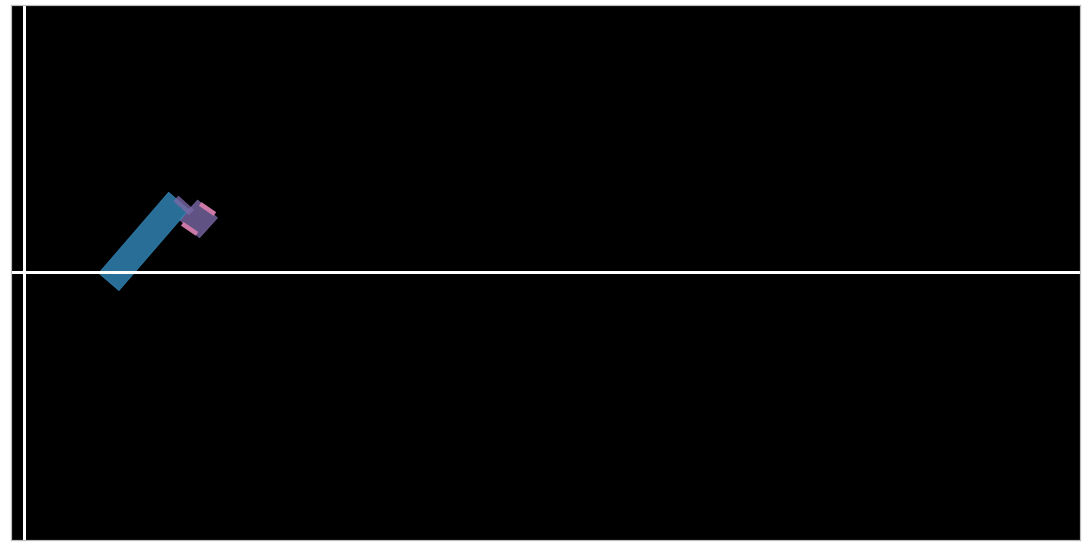

In [1056]:
truck = Truck(display=True)
truck.reset()

In [ ]:
# load the model 
path = "truck_model_100.pth"
truck_model.load_state_dict(torch.load(path))

In [1089]:
# run the sequence to watch the truck park itself
truck.reset()
controller.eval()
emulator.eval()
truck.set_state(9+random(),  -8 + random() * 16, deg2rad(-3- + random() * 60), deg2rad(-30 + random() * 60))



def get_sequence(ϕ=None):

    ϕ = ϕ if ϕ is not None else truck.state()
    ϕ = torch.tensor(ϕ)
    target = torch.tensor([0.,0.,0.]).to(device)
    with torch.no_grad():
        controls, states = truck_model(torch.tensor(ϕ).to(device))
    steps = len(controls)
    print(states)
#     distance_to_goal = truck_model.criterion(ϕ[2:5], target).item()
#     if step_count % 10 == 0: print(distance_to_goal)
    step_distance = 1
    return controls, states

truck_model.eval()

step_count = 0 
sequence_count = 0
sequence_theshold = 10

if truck.valid():
    controls, states = get_sequence()
else:
     print ("invalid start")

while truck.valid():
    steering_angle = controls[step_count].clone().detach().cpu().item()
    print(steering_angle)
    ϕ = truck.step(steering_angle)
    truck.draw()
    step_count += 1
    sequence_count +=1

    if sequence_count > sequence_theshold * len(sequence):
        sequence, step_distance = get_sequence(ϕ)
        step_count = 0
        sequence_count = 0

print(f"actual final state: {truck.state()}")






# def get_control(ϕ=None):

#     ϕ = ϕ if ϕ is not None else truck.state()
#     print(ϕ[:6])
#     ϕ = torch.tensor(ϕ).to(device)
#     target = torch.tensor([0.,0.,0.]).to(device)
#     with torch.no_grad():
#         control = controller(ϕ)
#         next_predicted_φ_state = emulator(torch.cat([control, ϕ]))
# #         print(f"predicted state {next_predicted_φ_state}")
#     distance_to_goal = criterion(next_predicted_φ_state[2:5], target).item()
#     print(f"{distance_to_goal} remaining")
                                            
#     return control



# ϕ = None
# step_count = 0 
# sequence_count = 0
# sequence_theshold =  1
# step_distance = 1/10
# control = get_control(ϕ)


# while truck.valid():
#     steering_angle = control.item()
#     ϕ = truck.step(steering_angle, step_distance)

#     truck.draw()
#     step_count += 1
#     sequence_count +=1

#     if sequence_count > sequence_theshold:
#         # get a new sequence of moves based on our current positon
#         control = get_control(ϕ)
#         sequence_count = 0

print(f"actual final state: {truck.state()} in {step_count} steps")

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


tensor([[ 1.4887e-01, -1.5910e-01, -1.0246e-01, -4.1828e-01, -4.8400e-01,
         -9.8692e-01],
        [-7.0907e-02,  1.0488e-01, -1.8076e-01,  1.2434e-04,  1.9440e-02,
          7.4119e-02],
        [-6.7700e-02, -1.1984e-02, -5.8459e-02,  1.0203e-03, -4.4135e-02,
         -1.6955e-02],
        ...,
        [-5.8152e-02, -2.9009e-03, -5.4752e-02, -3.9486e-05, -5.3593e-02,
         -3.2504e-04],
        [-2.3598e-02,  1.6009e-02, -5.7348e-02, -4.4239e-04, -2.3852e-02,
          1.9150e-04],
        [-5.1542e-02,  1.5205e-03, -5.3913e-02, -3.1652e-04, -4.8577e-02,
          7.9951e-04]], device='cuda:0')
-0.009111756458878517
-0.050415389239788055
0.0007428347016684711
-0.20759356021881104
0.17384523153305054
-0.1705380529165268
-0.03599349781870842
0.04448450729250908
-0.09744027256965637
0.15659356117248535
0.07295359671115875
0.15557096898555756
-0.2364071011543274
-0.02677903138101101
0.11371120065450668
0.07988834381103516
-0.23399339616298676
0.055106837302446365
-0.128451883792

In [579]:
print(truck.state())
print(truck.is_jackknifed())



(8.119742508836838, 6.116603859810737, -1.1498084874221415, 4.493594768052, 4.42809784501511, 0.4357897866324797)
True


In [314]:
import torch
import torch.nn as nn
from torch.optim import SGD
from tqdm import tqdm
from torch.autograd import Variable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [315]:
truck = Truck();

In [50]:
# Build expert data set

# episodes = 10
inputs = list()
outputs = list()
truck = Truck(); episodes = 10_000  # uncooment for creating the data set

for episode in tqdm(range(episodes)):
    
    truck.reset()
    
    while truck.valid():
        initial_state = truck.state()
        ϕ = (random() - 0.5) * π / 2
        inputs.append((ϕ, *initial_state))
        outputs.append(truck.step(ϕ))
        truck.draw()

100%|██████████| 10000/10000 [00:21<00:00, 471.83it/s]


In [95]:
len(inputs), len(outputs)

(598416, 598416)

In [923]:
state_size = 6
steering_size = 1
hidden_units_e = 45

emulator = nn.Sequential(
    nn.Linear(steering_size + state_size, hidden_units_e),
    nn.ReLU(),
    nn.Linear(hidden_units_e, state_size)
)

optimiser_e = SGD(emulator.parameters(), lr=0.005)
criterion = nn.MSELoss()

emulator = emulator.to(device)

In [93]:
tensor_inputs = torch.Tensor(inputs)
tensor_outputs = torch.Tensor(outputs)

In [182]:
tensor_inputs = torch.load('tensor_inputs.pt')
tensor_outputs = torch.load('tensor_outputs.pt')

In [15]:
# torch.save(tensor_inputs, 'tensor_inputs.pt')
# torch.save(tensor_outputs, 'tensor_outputs.pt')

In [54]:
mean = tensor_inputs.mean(0)
std = tensor_inputs.std(0)
tensor_inputs = (tensor_inputs - mean) / std
tensor_outputs = (tensor_outputs - mean[1:]) / std[1:]

In [55]:
# Split the data into 80:20 for test:train.
test_size = int(len(tensor_inputs) * 0.8)
print(len(tensor_inputs), test_size)

train_inputs = tensor_inputs[:test_size]
train_outputs = tensor_outputs[:test_size]
test_inputs = tensor_inputs[test_size:]
test_outputs = tensor_outputs[test_size:]

598416 478732


In [929]:
train_inputs = torch.load('train_inputs.pt')
train_outputs = torch.load('train_outputs.pt')
test_inputs = torch.load('test_inputs.pt')
test_outputs = torch.load('test_outputs.pt')


# torch.save(train_inputs, 'train_inputs.pt')
# torch.save(train_outputs, 'train_outputs.pt')
# torch.save(test_inputs, 'test_inputs.pt')
# torch.save(test_outputs, 'test_outputs.pt')

# train_inputs = Variable(train_inputs.to(device), requires_grad=True) # add gradients so that we can backprop
# train_outputs = Variable(train_outputs.to(device), requires_grad=True)

train_inputs = train_inputs.to(device)
train_outputs = train_outputs.to(device)

In [97]:
len(train_inputs)

478732

In [255]:
# Train... BUG! Can you spot it?
# What is one of the main assumptions for training a net?


cnt = 0
for i in torch.randperm(len(train_inputs)):
    ϕ_state = train_inputs[i]
    next_state_prediction = emulator(ϕ_state)
    
    next_state = train_outputs[i]
    loss = criterion(next_state_prediction, next_state)
    
    optimiser_e.zero_grad()
    loss.backward()
    optimiser_e.step()
    
    if cnt == 0 or (cnt + 1) % 1000 == 0:
        print(f'{cnt + 1:4d} / {len(train_inputs)}, {loss.item():.10f}')
    cnt += 1

   1 / 478732, 3.7552726269
1000 / 478732, 0.0660026968
2000 / 478732, 0.0244342312
3000 / 478732, 0.0444821864
4000 / 478732, 0.0315322131
5000 / 478732, 0.0445990153
6000 / 478732, 0.0271943305
7000 / 478732, 0.0052760490
8000 / 478732, 0.0034014853
9000 / 478732, 0.0029184276
10000 / 478732, 0.0148350215
11000 / 478732, 0.0107723894
12000 / 478732, 0.0121877613
13000 / 478732, 0.0074974890
14000 / 478732, 0.0108324885
15000 / 478732, 0.0069598989
16000 / 478732, 0.0014091845
17000 / 478732, 0.0110562369
18000 / 478732, 0.0031807527
19000 / 478732, 0.0072979084
20000 / 478732, 0.0032793463
21000 / 478732, 0.0033648231
22000 / 478732, 0.0070613748
23000 / 478732, 0.0024894399
24000 / 478732, 0.0023177809
25000 / 478732, 0.0027218983
26000 / 478732, 0.0012998306
27000 / 478732, 0.0011685048
28000 / 478732, 0.0027073026
29000 / 478732, 0.0008529336
30000 / 478732, 0.0031290960
31000 / 478732, 0.0050052237
32000 / 478732, 0.0015027403


KeyboardInterrupt: 

In [914]:
# load the emulator model
path = "emulator-orig.pth"
emulator.load_state_dict(torch.load(path))
emulator.eval()

Sequential(
  (0): Linear(in_features=7, out_features=45, bias=True)
  (1): ReLU()
  (2): Linear(in_features=45, out_features=6, bias=True)
)

In [62]:
path = "emulator-orig.pth"
torch.save(emulator.state_dict(), path)

In [259]:
# Test

emulator.eval()
emulator_validation_loss = 0
with torch.no_grad():
    for idx, ϕ_state in enumerate(test_inputs):
        next_state_prediction = emulator(ϕ_state)
        
        next_state = test_outputs[idx]
        emulator_validation_loss += criterion(next_state_prediction, next_state).item()

    

In [260]:
print(f'Test loss: {emulator_validation_loss:.10f}')

Test loss: 14.9818544427


In [912]:
state_size = 6
steering_size = 1
hidden_units_c = 25

class HalfPiSigmoid(nn.Module):
    """Returns Sigmoid with the range -pi/2 to pi/2 """
    def forward(self, x):
        return (torch.sigmoid(x) - 0.5) * pi


controller = nn.Sequential(
    nn.Linear(state_size, hidden_units_c),
    nn.ReLU(),
    nn.Linear(hidden_units_c, steering_size),
    HalfPiSigmoid()
)

optimiser_c = SGD(emulator.parameters(), lr=0.005)
criterion_c = nn.MSELoss()

controller = controller.to(device)

In [764]:
# pretrain the controller layer with the training dataset

train_inputs = train_inputs.to(device)
train_outputs = train_outputs.to(device)
emulator.eval()
controller.train()

cnt = 0
for i in torch.randperm(len(train_inputs)):
    ϕ_state = train_inputs[i]
    next_control_prediction = controller(ϕ_state[1:])

    next_state_prediction = emulator(torch.cat([next_control_prediction, ϕ_state[1:]]))

    next_state = train_outputs[i]
    loss = criterion(next_state_prediction, next_state)
    
    optimiser_c.zero_grad()
    loss.backward()
    optimiser_c.step()
    
    if cnt == 0 or (cnt + 1) % 1000 == 0:
        print(f'{cnt + 1:4d} / {len(train_inputs)}, {loss.item():.10f}')
    cnt += 1

   1 / 478732, 0.0002908290
1000 / 478732, 0.0002583290


KeyboardInterrupt: 

In [129]:
# Test
test_inputs = test_inputs.to(device)
test_outputs = test_outputs.to(device)

controller.eval()
controller_validation_loss = 0
with torch.no_grad():
    for idx, ϕ_state in enumerate(test_inputs):
        next_state_prediction = emulator(torch.cat([next_control_prediction, ϕ_state[1:]]))

        next_state = test_outputs[idx]
        controller_validation_loss += criterion(next_state_prediction, next_state).item()

    

In [130]:
print(f'Test loss: {controller_validation_loss:.10f}')

Test loss: 19.5865288292


In [519]:
path = "controller.pth"
controller.load_state_dict(torch.load(path))
controller.eval()

Sequential(
  (0): Linear(in_features=6, out_features=25, bias=True)
  (1): ReLU()
  (2): Linear(in_features=25, out_features=1, bias=True)
  (3): HalfPiSigmoid()
)

In [518]:
# save the pretrained controller model
path = "controller.pth"
torch.save(controller.state_dict(), path)

In [921]:
# Here you need to insert the code for training the controller
# by using the emulator for backpropagation

# If you succeed, feel free to send a PR



class CustomSigmoid(nn.Module):
    """Returns Sigmoid with the range -1 to 1 """
    def forward(self, x):
        return (torch.sigmoid(x) - 0.5) * 2


class ControllerLayer(nn.Module):
    def __init__(self, input_size=6, n_hidden=25, output_size=1):
        super(ControllerLayer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            HalfPiSigmoid()
        )
        self.control = []
    def forward(self, x):
        #x = x.view(-1, self.input_size)
        return self.network(x)
    
class TruckBackerUpper(nn.Module):
    def __init__(self, input_size=1, n_feature=6, output_size=1, n_layers=400, 
                 lr=0.1, momentum=0.9, docking_threshold=2, docking_goal=0.25, allowed_moves_before_docked=5):
        super(TruckBackerUpper, self).__init__()
        self.n_feature = n_feature
        self.n_layers = n_layers
        self.emulator = emulator
        self.control_layers = []
        self.lr = lr
        self.momentum = momentum
        for i in range(self.n_layers):
            self.control_layers.append(ControllerLayer())
        self.layers = nn.ModuleList(self.control_layers)
        self.steering_control = []
        self.optimizer = SGD(self.parameters(), lr=self.lr, momentum=self.momentum)
        self.criterion = nn.MSELoss()
        self.docking_threshold = docking_threshold
        self.docking_goal = docking_goal
        self.allowed_moves_before_docked = allowed_moves_before_docked
    
    def is_jackknifed(self, current_state):
        θ0 = current_state[2].item()
        θ1 = current_state[5].item()
        return abs(θ0 - θ1) * 180 / pi > 90

    def is_stalled(self, state, next_state):
        return self.criterion(state, next_state) < 0.00001

    def is_moving_wrong_way(self, current_state, start_state, target):
        return self.criterion(current_state[3:], target) - self.criterion(start_state[3:], target) > 20

    def is_driving_in_circles(self, steps):
        return steps > 2_000

    def is_offscreen(self, next_state):
        W = 1  # car and trailer width, for drawing only
        L = 1 * W  # car length
        d = 4 * L  # d_1

        x, y, θ0, x2, y2, θ1 = next_state.detach()
        x, y, θ0, x2, y2, θ1 = x.to(device), y.to(device), θ0.to(device), x2.to(device), y2.to(device), θ1.to(device)

        x1, y1 = x + 1.5 * L * cos(θ0.cpu()), y + 1.5 * L * sin(θ0.cpu())

        b = [0, 40, -10, 10] # screen size
        return not (
            b[0] <= x1 <= b[1] and b[2] <= y1 <= b[3] and
            b[0] <= x2 <= b[1] and b[2] <= y2 <= b[3]
        )

    def is_docked(self, this_state, last_state, target, moves_inside_dock):
        last_loss = self.criterion(last_state[3:], target)
        this_loss = self.criterion(this_state[3:], target)
        within_dock_threshold = this_loss < self.docking_threshold
        moving_toward_dock = this_loss < last_loss
        if within_dock_threshold and not moving_toward_dock:
            moves_inside_dock += 1
            if moves_inside_dock > self.allowed_moves_before_docked:
                return True, moves_inside_dock, this_loss
            if this_loss < self.docking_goal:
                return True, moves_inside_dock, this_loss
        else:
            moves_inside_dock = 0
        return False, moves_inside_dock, this_loss
    
    def freeze_model(self):
        self.eval()
        for name, child in self.named_children():
            for param in child.parameters():
                param.requires_grad = False
            
    def unfreeze_model(self):
        self.train()
        for name, child in self.named_children():
            for param in child.parameters():
                param.requires_grad = True
        
    def forward(self, x, verbose=False):
        state = x
        steering_controls = []
        states = []
        for i, l in enumerate(self.control_layers):
            steering_amount = self.control_layers[i](state) 
            steering_controls.append(steering_amount)
            state = emulator(torch.cat([steering_amount, state]))
            states.append(state)
        control_sequence = torch.stack(steering_controls).view(-1, 1)
        states = torch.stack(states).view(-1, 6)
        
        return control_sequence, states

In [925]:
emulator = emulator.to(device)

n_layers = 200 # per the paper should be 4 * number of steps per sequence
truck_model = TruckBackerUpper(n_layers=n_layers, lr=0.005, docking_goal=2, docking_threshold=15)

#truck_model = TruckBackerUpper(n_layers=n_layers, lr=0.9, momentum=0.9, docking_goal=5)
truck_model = truck_model.to(device)

truck_model.train()

TruckBackerUpper(
  (emulator): Sequential(
    (0): Linear(in_features=7, out_features=45, bias=True)
    (1): ReLU()
    (2): Linear(in_features=45, out_features=6, bias=True)
  )
  (layers): ModuleList(
    (0): ControllerLayer(
      (network): Sequential(
        (0): Linear(in_features=6, out_features=25, bias=True)
        (1): ReLU()
        (2): Linear(in_features=25, out_features=1, bias=True)
        (3): HalfPiSigmoid()
      )
    )
    (1): ControllerLayer(
      (network): Sequential(
        (0): Linear(in_features=6, out_features=25, bias=True)
        (1): ReLU()
        (2): Linear(in_features=25, out_features=1, bias=True)
        (3): HalfPiSigmoid()
      )
    )
    (2): ControllerLayer(
      (network): Sequential(
        (0): Linear(in_features=6, out_features=25, bias=True)
        (1): ReLU()
        (2): Linear(in_features=25, out_features=1, bias=True)
        (3): HalfPiSigmoid()
      )
    )
    (3): ControllerLayer(
      (network): Sequential(
       

In [932]:
# test whether pre-trained truck_model can predcit the test set
controller.train()
truck_model.eval()


truck_model_validation_loss = 0
with torch.no_grad():
    for idx, ϕ_state in enumerate(test_inputs):
        next_state_prediction = truck_model(ϕ_state.to(device)[1:])[1][0]

        next_state = test_outputs[idx].to(device)
        truck_model_validation_loss += criterion(next_state_prediction, next_state).item()


KeyboardInterrupt: 

In [933]:
print(f'Test loss: {truck_model_validation_loss:.10f}')

Test loss: 5350.5523131937


In [1051]:
# training code using just the controller and emulator
truck = Truck()
emulator.eval()
controller.train()

target = torch.tensor([0, 0, 0]).type(torch.float).to(device)
cnt = 0

running_loss = 0
last_running_loss = inf
running_step_count = 0
steps = 0
batch_steps = 0
early_stop_threshold = 5
successful_runs = 0
jackknifes = 0


iterations = 10_000
# iterations = len(train_inputs)

for epoch in range(5):
    for i in torch.randperm(len(train_outputs)):
#     for i in range(5000,5001):
        
        controller.zero_grad()
        emulator.zero_grad()

        batch_steps += steps
        steps = 0
        emulator_steps = 0
        truck_steps = 0

        stop_conditions = False
        x = 7 + random()
        y = -5 + random() * 10
        θ0 = deg2rad(-15 + random() * 30)
        θ1 = deg2rad(-15 + random() * 30) 
        
        truck.set_state(x=x, y=y,θ0=θ0, θ1=θ1 )
#         print(truck.state())

#         ϕ_state = train_inputs[i][1:]
        ϕ_state = torch.tensor(truck.state(), requires_grad=True).to(device)
        initial_ϕ_state = ϕ_state.clone()
    
        if not truck.valid():
            print ("invalid start")
            continue


        start_state = f"({ϕ_state[3].item():.2f},{ϕ_state[4].item():.2f},{ϕ_state[5].item():.2f})"
        last_ϕ_state = ϕ_state
        last_actual_ϕ_state = ϕ_state

        sum_loss = 0
        moves_inside_dock = 0 
        step_distance = 1

   

        # next we'll compare the emulated postion to the actual position of our truck
        
        loss_truck = 0
        loss_actual = 0

        best_loss = inf
        
#         x, y, θ0, x2, y2, θ1 = ϕ_state.clone().detach().cpu().numpy()
#         truck.set_state(x, y, θ0, θ1)
# #         truck.draw()

        stop_conditions = False
        docked = False
        loss_truck = 0
        
        
        while truck.valid():
            x, y, θ0, x2, y2, θ1 = ϕ_state.clone().detach()
#             truck.set_state(x, y, θ0, θ1)
#             print(f"truck state {truck.state()}")

#             print(f"control {control}")
            truck_ϕ_state = torch.tensor(truck.state(), requires_grad=True).to(device)
    
            predicted_steering_control = controller(truck_ϕ_state)
            control = predicted_steering_control.clone().detach().cpu().item()
#             print(f"truck state {truck_ϕ_state}")
#             print(f"predicted control {predicted_steering_control}")
            next_truck_ϕ_state = truck.step(control)
#             print(f"next truck state {next_truck_ϕ_state}")
            if truck.valid():
                steps += 1
                ϕ_state = emulator(torch.cat([predicted_steering_control, truck_ϕ_state]))
#                 print(f"emulated state {ϕ_state} ")
                loss_truck += criterion_c(ϕ_state[3:4], target[0:1]) / steps  # make it to the target
                loss_truck += criterion_c(θ0, θ1) / (1 / steps) # don't jackknife
                
#             
        loss_truck +=  criterion_c(ϕ_state[3:4], target[0:1])  / (steps) # make it to the target
        loss_truck += criterion_c(ϕ_state[5], target[2]) / steps
        loss_truck += criterion_c(θ0, θ1) ** 4
        
#         if truck.is_jackknifed():
#             print(f"jackknife loss {criterion_c(θ0, θ1)}")
 
#         k_state = initial_ϕ_state
#         x, y, θ0, x2, y2, θ1 = k_state.clone().detach()
#         x, y, θ0, x2, y2, θ1 = x.item(), y.item(), θ0.item(), x2.item(), y2.item(), θ1.item()
# #         print(f"x {x}, y {y}, θ0 {θ0}, x2 {x2}, y2 {y2}, θ1 {θ1}")
#         truck.set_state(x, y, θ0, θ1)
# #         print(f"truck state: {truck.state()}")
# #         print(f"k_state: {k_state}")
        
#         while truck.valid():
#             truck_ϕ_state = torch.tensor(truck.state(), requires_grad=True).to(device)
#             next_truck_ϕ_state = truck.step(control)
#             if truck.valid:
#                 k_state = emulator(torch.cat([predicted_steering_control, truck_ϕ_state]))



            
    
        actual_final_state = f"({next_truck_ϕ_state[3].item():.2f},{next_truck_ϕ_state[4].item():.2f},{next_truck_ϕ_state[5].item():.2f})"
        predicted_final_state = f"({ϕ_state[3].item():.2f},{ϕ_state[4].item():.2f},{ϕ_state[5].item():.2f})"

        

                 
        
        jackknifed = truck.is_jackknifed()
        offscreen = truck.is_offscreen()

                
                
        
        if docked and not jackknifed:
            successful_runs += 1

        if jackknifed:
            jackknifes += 1





        final_loss = loss_truck.item()
        loss_truck.backward()
        
        optimiser_c.step()


        running_loss += final_loss
        running_step_count += steps

        display_threshold = 100

        if cnt == 0 or (cnt + 1) % display_threshold == 0:
            print(f'{cnt + 1:3d}, item loss: {final_loss:.3f}, steps: {steps:3d}, start state: {start_state}, predicted final state: {predicted_final_state}, actual final state: {actual_final_state}, last move: {control:.3f}, docked: {docked}, jackknifed: {jackknifed}, offscreen: {offscreen}')
        cnt += 1

        summary_threshold = 500

        if (cnt + 1) % summary_threshold == 0:
            print(f"\n\nSuccess rate: {successful_runs} / {summary_threshold}, avg loss: {running_loss/summary_threshold:.3f}, avg steps:  {running_step_count/summary_threshold:2f} jackknifes: {jackknifes}")


            if running_loss > last_running_loss:
                early_stop_count += 1
            else:
                early_stop_count = 0

            print(f"\nEarly Stop: {early_stop_count} / {early_stop_threshold}\n\n")



            if early_stop_count > early_stop_threshold:
                break

            last_running_loss = running_loss
            running_loss = 0
            running_step_count = 0
            successful_runs = 0
            jackknifes = 0
    

  1, item loss: 104.172, steps:  27, start state: (3.70,4.15,0.12), predicted final state: (-0.41,-0.30,-0.20), actual final state: (1.69,3.96,-0.20), last move: -0.536, docked: False, jackknifed: True, offscreen: False
100, item loss: 15.617, steps:  12, start state: (3.91,-1.62,-0.19), predicted final state: (-0.21,-0.33,-0.64), actual final state: (3.07,-1.49,0.01), last move: 0.758, docked: False, jackknifed: True, offscreen: False
200, item loss: 38.788, steps:  34, start state: (3.62,2.30,0.10), predicted final state: (-0.15,-0.08,-0.25), actual final state: (1.13,2.30,-0.38), last move: -0.361, docked: False, jackknifed: True, offscreen: False
300, item loss: 31.711, steps:  37, start state: (3.60,1.23,0.20), predicted final state: (0.07,-0.26,-0.02), actual final state: (-0.06,0.27,0.29), last move: -0.153, docked: False, jackknifed: False, offscreen: True
400, item loss: 6.543, steps:   7, start state: (3.06,-3.76,-0.09), predicted final state: (-0.22,-0.23,-0.73), actual fina

KeyboardInterrupt: 

In [1055]:
# training code truck with new strategy
truck = Truck()
truck_model.train()
emulator.eval()

target = torch.tensor([0, 0, 0]).type(torch.float).to(device)
cnt = 0

running_loss = 0
last_running_loss = inf
running_step_count = 0
steps = 0
batch_steps = 0
early_stop_threshold = 5
successful_runs = 0
jackknifes = 0


iterations = 10_000
# iterations = len(train_inputs)

for epoch in range(5):
    for i in torch.randperm(len(train_outputs)):
#     for i in range(5000,5001):

#     for i in range(5000,5001):

        
        truck_model.zero_grad()
        emulator.zero_grad()
        
        batch_steps += steps
        steps = 0
        emulator_steps = 0
        truck_steps = 0

        stop_conditions = False
        truck.reset()
        
        x = 8 + random()
        y = -8 + random() * 16
        θ0 = deg2rad(-15 + random() * 30)
        θ1 = deg2rad(-15 + random() * 30) 
        
        truck.set_state(x=x, y=y,θ0=θ0, θ1=θ1 )
#         print(truck.state())

#         ϕ_state = train_inputs[i][1:]
        ϕ_state = torch.tensor(truck.state(), requires_grad=True).to(device)

    
        if not truck.valid():
            print ("invalid start")
            continue


        sum_loss = 0
        moves_inside_dock = 0 
        step_distance = 1

                            
        # get the prediction
        predicted_steering_controls, predicted_ϕ_states = truck_model(ϕ_state)
        
#         print(predicted_steering_controls)
#         print(predicted_ϕ_states)
#         break
        
        number_of_predicted_steps = len(predicted_ϕ_states)
        step_distance =  1
#         step_distance = 1

        # next we'll compare the emulated postion to the actual position of our truck
        
        loss_truck = 0
        loss_actual = 0

        best_loss = inf
        
#         x, y, θ0, x2, y2, θ1 = ϕ_state.clone().detach().cpu().numpy()
#         truck.set_state(x, y, θ0, θ1)
# #         truck.draw()
        

        stop_conditions = False
        docked = False
                            
        
        while truck.valid() and (steps < number_of_predicted_steps):
            x, y, θ0, x2, y2, θ1 = ϕ_state.clone().detach()
            truck_ϕ_state = torch.tensor(truck.state(), requires_grad=True).to(device)
    
            predicted_steering_control = predicted_steering_controls[steps]
            control = predicted_steering_control.clone().detach().cpu().item()
#             print(f"truck state {truck_ϕ_state}")
#             print(f"predicted control {predicted_steering_control}")
            next_truck_ϕ_state = truck.step(control)
#             print(f"next truck state {next_truck_ϕ_state}")
            if truck.valid():
                steps += 1
                ϕ_state = predicted_ϕ_states[steps]
#                 print(f"emulated state {ϕ_state} ")
                loss_truck += truck_model.criterion(ϕ_state[3:4], target[0:1]) / steps  # make it to the target
                loss_truck += truck_model.criterion(θ0, θ1) / (1 / steps) # don't jackknife
                
#             
        loss_truck +=  truck_model.criterion(ϕ_state[3:4], target[0:1])  / (steps) # make it to the target
        loss_truck +=  truck_model.criterion(torch.tensor(next_truck_ϕ_state).to(device), target[0:1])  / (steps) # make it to the target
        loss_truck += truck_model.criterion(ϕ_state[5], target[2]) /steps
        loss_truck += truck_model.criterion(θ0, θ1) ** 4
        
#         if truck.is_jackknifed():
#             print(f"jackknife loss {criterion_c(θ0, θ1)}")
 
#         k_state = initial_ϕ_state
#         x, y, θ0, x2, y2, θ1 = k_state.clone().detach()
#         x, y, θ0, x2, y2, θ1 = x.item(), y.item(), θ0.item(), x2.item(), y2.item(), θ1.item()
# #         print(f"x {x}, y {y}, θ0 {θ0}, x2 {x2}, y2 {y2}, θ1 {θ1}")
#         truck.set_state(x, y, θ0, θ1)
# #         print(f"truck state: {truck.state()}")
# #         print(f"k_state: {k_state}")
        
#         while truck.valid():
#             truck_ϕ_state = torch.tensor(truck.state(), requires_grad=True).to(device)
#             next_truck_ϕ_state = truck.step(control)
#             if truck.valid:
#                 k_state = emulator(torch.cat([predicted_steering_control, truck_ϕ_state]))



            
    
        actual_final_state = f"({next_truck_ϕ_state[3].item():.2f},{next_truck_ϕ_state[4].item():.2f},{next_truck_ϕ_state[5].item():.2f})"
        predicted_final_state = f"({ϕ_state[3].item():.2f},{ϕ_state[4].item():.2f},{ϕ_state[5].item():.2f})"

        

                 
        
        jackknifed = truck.is_jackknifed()
        offscreen = truck.is_offscreen()
                            
#         while truck.valid() and (steps < number_of_predicted_steps):
#             steering_angle = predicted_steering_controls[steps].item()

#             next_predicted_ϕ_state = predicted_ϕ_states[steps]
#             next_actual_ϕ_state = torch.tensor(truck.step(steering_angle, step_distance)).to(device)

#             loss_target += truck_model.criterion(next_predicted_ϕ_state, next_actual_ϕ_state) # loss for not moving to the correct state
# #             loss_target += truck_model.criterion(next_predicted_ϕ_state[3:], target) 

#             actual_final_state = f"({next_actual_ϕ_state[3].item():.2f},{next_actual_ϕ_state[4].item():.2f},{next_actual_ϕ_state[5].item():.2f})"
#             predicted_final_state = f"({next_predicted_ϕ_state[3].item():.2f},{next_predicted_ϕ_state[4].item():.2f},{next_predicted_ϕ_state[5].item():.2f})"
           
#             jackknifed = truck.is_jackknifed()
#             offscreen = truck.is_offscreen()

#             steps += 1
        
#         loss_target += truck_model.criterion(next_predicted_ϕ_state[3:], target) # loss for not reaching goal
            
#         if docked and not jackknifed:
#             successful_runs += 1

        if jackknifed:
            jackknifes += 1


        loss_truck.backward()



        truck_model.optimizer.step()
        
        final_loss = loss_truck.item()

        running_loss += final_loss
        running_step_count += steps

        display_threshold = 100

        if cnt == 0 or (cnt + 1) % display_threshold == 0:
            print(f'{cnt + 1:3d}, item loss: {final_loss:.3f}, steps: {steps:3d}, start state: {start_state}, predicted final state: {predicted_final_state}, actual final state: {actual_final_state}, last move: {control:.3f}, docked: {docked}, jackknifed: {jackknifed}, offscreen: {offscreen}')
        cnt += 1

        summary_threshold = 500

        if (cnt + 1) % summary_threshold == 0:
            print(f"\n\nSuccess rate: {successful_runs} / {summary_threshold}, avg loss: {running_loss/summary_threshold:.3f}, avg steps:  {running_step_count/summary_threshold:2f} jackknifes: {jackknifes}")


            if running_loss > last_running_loss:
                early_stop_count += 1
            else:
                early_stop_count = 0

            print(f"\nEarly Stop: {early_stop_count} / {early_stop_threshold}\n\n")



            if early_stop_count > early_stop_threshold:
                break

            last_running_loss = running_loss
            running_loss = 0
            running_step_count = 0
            successful_runs = 0
            jackknifes = 0
    

  1, item loss: 3.869, steps:  48, start state: (3.19,4.54,0.10), predicted final state: (-0.00,-0.05,0.00), actual final state: (-0.09,-2.38,0.05), last move: -0.083, docked: False, jackknifed: False, offscreen: True
100, item loss: 10.201, steps:  79, start state: (3.19,4.54,0.10), predicted final state: (-0.00,-0.05,-0.00), actual final state: (0.33,-4.24,-1.40), last move: -0.097, docked: False, jackknifed: True, offscreen: False
200, item loss: 3.932, steps:  47, start state: (3.19,4.54,0.10), predicted final state: (0.00,-0.03,-0.00), actual final state: (-0.06,-4.65,-0.53), last move: 0.096, docked: False, jackknifed: False, offscreen: True
300, item loss: 3.723, steps:  47, start state: (3.19,4.54,0.10), predicted final state: (0.00,-0.03,-0.00), actual final state: (-0.03,-4.94,0.22), last move: 0.096, docked: False, jackknifed: False, offscreen: True
400, item loss: 7.115, steps:  67, start state: (3.19,4.54,0.10), predicted final state: (-0.00,-0.03,0.00), actual final state

KeyboardInterrupt: 

In [889]:
# training code
truck = Truck()
truck_model.train()
emulator.eval()
controller.train()

target = torch.tensor([0, 0, 0]).type(torch.float).to(device)
cnt = 0

running_loss = 0
last_running_loss = inf
running_step_count = 0
steps = 0
batch_steps = 0
early_stop_threshold = 5
successful_runs = 0
jackknifes = 0


iterations = 10_000
# iterations = len(train_inputs)

for epoch in range(5):
    for i in torch.randperm(len(train_inputs):
#     for i in range(5000,5001):


        batch_steps += steps
        steps = 0
        emulator_steps = 0
        truck_steps = 0

        stop_conditions = False
        truck.reset()

#         ϕ_state = train_inputs[i][1:]
        ϕ_state = torch.tensor(truck.state(), requires_grad=True).to(device)


        start_state = f"({ϕ_state[3].item():.2f},{ϕ_state[4].item():.2f},{ϕ_state[5].item():.2f})"
        last_ϕ_state = ϕ_state
        last_actual_ϕ_state = ϕ_state

        sum_loss = 0
        moves_inside_dock = 0 

        # get the prediction
        predicted_steering_controls, predicted_ϕ_states = truck_model(ϕ_state)
        
        
        number_of_predicted_steps = len(predicted_ϕ_states)
        step_distance =  1
#         step_distance = 1

        # next we'll compare the emulated postion to the actual position of our truck
        
        loss_target = 0
        loss_actual = 0

        best_loss = inf
        
#         x, y, θ0, x2, y2, θ1 = ϕ_state.clone().detach().cpu().numpy()
#         truck.set_state(x, y, θ0, θ1)
# #         truck.draw()
        
        docked, _, __ = truck_model.is_docked(ϕ_state, ϕ_state,  target, 0)
        if (not truck.valid()) or docked:
            # quite a few items in the dataset are invalid
            invalid_count += 1
            continue


        stop_conditions = False
        docked = False
    
        while not docked and truck.valid() and (steps < number_of_predicted_steps):
            steering_angle = predicted_steering_controls[steps].item()

            next_predicted_ϕ_state = predicted_ϕ_states[steps]
            next_actual_ϕ_state = torch.tensor(truck.step(steering_angle, step_distance)).to(device)
            
#             next_actual_ϕ_state = Variable(torch.tensor(next_actual_ϕ_state).to(device), requires_grad=True)
#             if steps == len(steering_controls):
#                 # take one more step to reach the goal
#                 next_ϕ_state = emulator(torch.cat([truck_model(next_ϕ_state)[6], next_ϕ_state]))
#                 steps += 1

            # if we stop moving we'll break out of the loop and use this state to backprop through time
#            print(next_predicted_ϕ_state)


#             # possible conditions to indicate a stopped state
#             jackknifed = truck_model.is_jackknifed(next_ϕ_state)
#             moving_wrong_way = truck_model.is_moving_wrong_way(next_ϕ_state, ϕ_state, target)
#             stalled = truck_model.is_stalled(last_ϕ_state, next_ϕ_state)
#             driving_in_circles = truck_model.is_driving_in_circles(steps)
            docked, moves_inside_dock, distance_to_dock = truck_model.is_docked(next_actual_ϕ_state, last_actual_ϕ_state,  target, moves_inside_dock)
#             offscreen = truck_model.is_offscreen(next_ϕ_state)

#             # the conditions we're using
#             stop_conditions = jackknifed or offscreen 

#             if steps % 10 == 0:
#                 print(f"distance to goal {distance_to_dock.item():.2f}")

            loss_target += truck_model.criterion(next_predicted_ϕ_state, next_actual_ϕ_state) # loss for not moving to the correct state
#             loss_target += truck_model.criterion(next_predicted_ϕ_state[3:], target) 

            actual_final_state = f"({next_actual_ϕ_state[3].item():.2f},{next_actual_ϕ_state[4].item():.2f},{next_actual_ϕ_state[5].item():.2f})"
            predicted_final_state = f"({next_predicted_ϕ_state[3].item():.2f},{next_predicted_ϕ_state[4].item():.2f},{next_predicted_ϕ_state[5].item():.2f})"
           
            jackknifed = truck.is_jackknifed()
            offscreen = truck.is_offscreen()

            steps += 1
        
        loss_target += truck_model.criterion(next_predicted_ϕ_state[3:], target) # loss for not reaching goal
            
        if docked and not jackknifed:
            successful_runs += 1

        if jackknifed:
            jackknifes += 1

        

        loss_target.backward()

        truck_model.zero_grad()

        truck_model.optimizer.step()
        
        final_loss = loss_target.item()

        running_loss += final_loss
        running_step_count += steps

        display_threshold = 100

        if cnt == 0 or (cnt + 1) % display_threshold == 0:
            print(f'{cnt + 1:3d}, item loss: {final_loss:.3f}, steps: {steps:3d}, start state: {start_state}, predicted final state: {predicted_final_state}, actual final state: {actual_final_state}, last move: {steering_angle:.3f}, docked: {docked}, jackknifed: {jackknifed}, offscreen: {offscreen}')
        cnt += 1

        summary_threshold = 500

        if (cnt + 1) % summary_threshold == 0:
            print(f"\n\nSuccess rate: {successful_runs} / {summary_threshold}, avg loss: {running_loss/summary_threshold:.3f}, avg steps:  {running_step_count/summary_threshold:2f} jackknifes: {jackknifes}")


            if running_loss > last_running_loss:
                early_stop_count += 1
            else:
                early_stop_count = 0

            print(f"\nEarly Stop: {early_stop_count} / {early_stop_threshold}\n\n")



            if early_stop_count > early_stop_threshold:
                break

            last_running_loss = running_loss
            running_loss = 0
            running_step_count = 0
            successful_runs = 0
            jackknifes = 0
    

SyntaxError: invalid syntax (<ipython-input-889-321f369134a3>, line 24)

In [ ]:
# # training code
# truck = Truck()
# truck_model.train()
# emulator.train()

# target = torch.tensor([0, 0, 0]).type(torch.float).to(device)
# cnt = 0

# running_loss = 0
# last_running_loss = inf
# running_step_count = 0
# steps = 0
# batch_steps = 0
# early_stop_threshold = 5
# successful_runs = 0
# jackknifes = 0


# iterations = 100_000
# # iterations = len(train_inputs)

# for epoch in range(5):
#     for i in torch.randperm(iterations):
# #     for i in range(5000,5001):


#         batch_steps += steps
#         steps = 0
#         emulator_steps = 0
#         truck_steps = 0

#         stop_conditions = False
#         truck.reset()

# #         ϕ_state = train_inputs[i][1:]
#         ϕ_state = torch.tensor(truck.state(), requires_grad=True).to(device)


#         start_state = f"({ϕ_state[3].item():.2f},{ϕ_state[4].item():.2f},{ϕ_state[5].item():.2f})"
#         last_ϕ_state = ϕ_state
#         last_actual_ϕ_state = ϕ_state

#         sum_loss = 0
#         moves_inside_dock = 0 

#         # get the prediction
#         predicted_steering_controls, predicted_ϕ_states = truck_model(ϕ_state)
        
        
#         number_of_predicted_steps = len(predicted_ϕ_states)
#         step_distance =  1/20
# #         step_distance = 1

#         # next we'll compare the emulated postion to the actual position of our truck
        
#         loss_target = 0
#         loss_actual = 0

#         best_loss = inf
        
# #         x, y, θ0, x2, y2, θ1 = ϕ_state.clone().detach().cpu().numpy()
# #         truck.set_state(x, y, θ0, θ1)
# # #         truck.draw()
        
#         docked, _, __ = truck_model.is_docked(ϕ_state, ϕ_state,  target, 0)
#         if (not truck.valid()) or docked:
#             # quite a few items in the dataset are invalid
#             invalid_count += 1
#             continue


#         stop_conditions = False
#         docked = False
        
#         steering_angle = predicted_steering_controls[0]
#         next_predicted_ϕ_state = predicted_ϕ_states[0]
#         next_actual_ϕ_state = torch.tensor(truck.step(steering_angle.clone().detach().item(), 1)).to(device)
        
#         loss_target += truck_model.criterion(next_predicted_ϕ_state, next_actual_ϕ_state) 
        
        
#         while not docked and not offscreen and not jackknifed and (steps < number_of_predicted_steps):

#             next_predicted_ϕ_state = emulator(torch.cat([steering_angle, next_predicted_ϕ_state]))
# #             next_actual_ϕ_state = Variable(torch.tensor(next_actual_ϕ_state).to(device), requires_grad=True)
# #             if steps == len(steering_controls):
# #                 # take one more step to reach the goal
# #                 next_ϕ_state = emulator(torch.cat([truck_model(next_ϕ_state)[6], next_ϕ_state]))
# #                 steps += 1

#             # if we stop moving we'll break out of the loop and use this state to backprop through time
# #            print(next_predicted_ϕ_state)


# #             # possible conditions to indicate a stopped state
#             jackknifed = truck_model.is_jackknifed(next_predicted_ϕ_state)
# #             moving_wrong_way = truck_model.is_moving_wrong_way(next_ϕ_state, ϕ_state, target)
# #             stalled = truck_model.is_stalled(last_ϕ_state, next_ϕ_state)
# #             driving_in_circles = truck_model.is_driving_in_circles(steps)
#             docked, moves_inside_dock, distance_to_dock = truck_model.is_docked(next_actual_ϕ_state, last_actual_ϕ_state,  target, moves_inside_dock)
#             offscreen = truck_model.is_offscreen(next_predicted_ϕ_state)

# #             # the conditions we're using
# #             stop_conditions = jackknifed or offscreen 

# #             if steps % 10 == 0:
# #                 print(f"distance to goal {distance_to_dock.item():.2f}")

# #             loss_target += truck_model.criterion(next_predicted_ϕ_state[3:], target) 

#             actual_final_state = f"({next_actual_ϕ_state[3].item():.2f},{next_actual_ϕ_state[4].item():.2f},{next_actual_ϕ_state[5].item():.2f})"
#             predicted_final_state = f"({next_predicted_ϕ_state[3].item():.2f},{next_predicted_ϕ_state[4].item():.2f},{next_predicted_ϕ_state[5].item():.2f})"
           
# #             jackknifed = truck.is_jackknifed()
# #             offscreen = truck.is_offscreen()

#             steps += 1
        
#         loss_target += truck_model.criterion(next_predicted_ϕ_state[3:], target) # extra penalty for not reaching goal
            
#         if docked and not jackknifed:
#             successful_runs += 1

#         if jackknifed:
#             jackknifes += 1

        

#         loss_target.backward()

#         truck_model.zero_grad()

#         truck_model.optimizer.step()
        
#         final_loss = loss_target.item()

#         running_loss += final_loss
#         running_step_count += steps

#         display_threshold = 100

#         if cnt == 0 or (cnt + 1) % display_threshold == 0:
#             print(f'{cnt + 1:3d}, item loss: {final_loss:.3f}, steps: {steps:3d}, start state: {start_state}, predicted final state: {predicted_final_state}, actual final state: {actual_final_state}, last move: {steering_angle.clone().detach().item():.3f}, docked: {docked}, jackknifed: {jackknifed}, offscreen: {offscreen}')
#         cnt += 1

#         summary_threshold = 1000

#         if (cnt + 1) % summary_threshold == 0:
#             print(f"\n\nSuccess rate: {successful_runs} / {summary_threshold}, avg loss: {running_loss/summary_threshold:.3f}, avg steps:  {running_step_count/summary_threshold:2f} jackknifes: {jackknifes}")


#             if running_loss > last_running_loss:
#                 early_stop_count += 1
#             else:
#                 early_stop_count = 0

#             print(f"\nEarly Stop: {early_stop_count} / {early_stop_threshold}\n\n")



#             if early_stop_count > early_stop_threshold:
#                 break

#             last_running_loss = running_loss
#             running_loss = 0
#             running_step_count = 0
#             successful_runs = 0
#             jackknifes = 0
    

In [ ]:
path = "truck_model_500.pth"
truck_model.load_state_dict(torch.load(path))

In [194]:
path = "truck_model_4000.pth"
torch.save(truck_model.state_dict(), path)